In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [ ]:
q.IBMQ.load_account() # Load account from disk

In [4]:
#provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
#backend = provider.get_backend('alt_almaden')
from qiskit.test.mock import FakeAlmaden
backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [5]:
beta, alpha = np.pi/2, np.pi/2

In [6]:
schedules = []

In [7]:
XXX = cmd_def.get('x', qubits=[0]) | cmd_def.get('x', qubits=[1])  | cmd_def.get('x', qubits=[2]) 
schedule = XXX

schedule |= cmd_def.get('u1', qubits=[2], P0=-np.pi/2) << schedule.duration # sdag(2)
HH = cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[2], P0=0, P1=np.pi)
schedule |= HH << schedule.duration

CNOT_RZ_CNOT = cmd_def.get('cx', qubits=[1, 2])
CNOT_RZ_CNOT |= cmd_def.get('u1', qubits=[2], P0=beta) << CNOT_RZ_CNOT.duration
CNOT_RZ_CNOT |= cmd_def.get('cx', qubits=[1, 2]) << CNOT_RZ_CNOT.duration
schedule |= CNOT_RZ_CNOT << schedule.duration

# H and then S on qubit 2
schedule |= cmd_def.get('u2', qubits=[2], P0=0, P1=np.pi) << schedule.duration
schedule |= cmd_def.get('u1', qubits=[2], P0=np.pi/2) << schedule.duration


# Sdag and then H on qubit 0
schedule |= cmd_def.get('u1', qubits=[0], P0=-np.pi/2) << schedule.duration
schedule |= cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) << schedule.duration

# CNOT RZ CNOT on qubits 0, 1
CNOT_RZ_CNOT = cmd_def.get('cx', qubits=[0, 1])
CNOT_RZ_CNOT |= cmd_def.get('u1', qubits=[1], P0=alpha) << CNOT_RZ_CNOT.duration
CNOT_RZ_CNOT |= cmd_def.get('cx', qubits=[0, 1]) << CNOT_RZ_CNOT.duration
schedule |= CNOT_RZ_CNOT << schedule.duration

# H on qubits 0, 1
HH = cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi)
schedule |= HH << schedule.duration

# S on qubit 0
schedule |= cmd_def.get('u1', qubits=[0], P0=np.pi/2)

schedule |= measure << schedule.duration

schedules.append(schedule)

In [8]:
## Optimized Way:
N = 3
circ = q.QuantumCircuit(N)
circ.x(0); circ.x(1); circ.x(2);  # start with |111>

#  exp(-i*beta* X_1 Y_2)
circ.h(1)
circ.sdg(2); circ.h(2)
circ.zz_interaction(beta, 1, 2)
circ.h(2); circ.s(2)

# exp(-i*alpha* Y_0 X_1)
circ.sdg(0); circ.h(0);
circ.cx(0, 1); circ.rz(alpha, 1);  circ.cx(0, 1);
circ.zz_interaction(alpha, 0, 1)
circ.h(0); circ.s(0);
circ.h(1)


decomposed_circuit = circ.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule |= measure << schedule.duration
schedules.append(schedule)

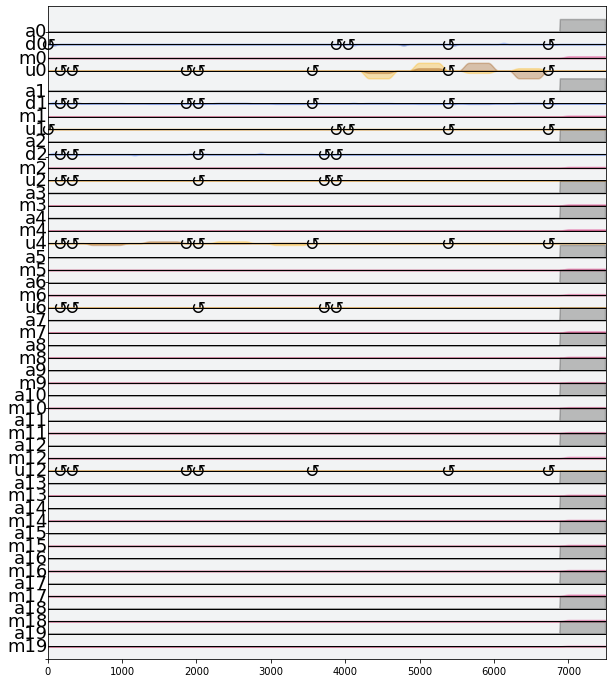

In [13]:
schedules[0].draw(table=False, plot_range=(0, 7500))

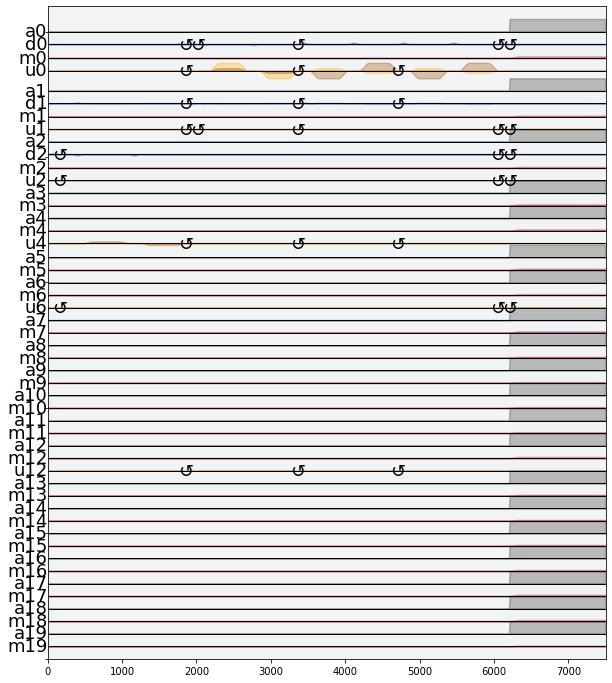

In [14]:
schedules[1].draw(table=False, plot_range=(0, 7500))

In [ ]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

In [ ]:
job.status()

# Run a mitigation cal job

In [ ]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)

In [ ]:
job_mit = q.execute(meas_schedules, backend, shots=shots)
print('job_mit is %s' % job_mit.job_id())

In [ ]:
job_mit.status()

-----
## Analysis

In [ ]:
from qiskit.result import marginal_counts

In [ ]:
result = job.result()

In [ ]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1,2])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

In [ ]:
standard_counts = marginal_counts(result.get_counts(0), [0,1,2])
print('before mitigation:')
print(standard_counts)

standard_counts = readout_fitter.filter.apply(standard_counts)
print('\n\n\n after mitigation:')
print(standard_counts)

In [ ]:
optimized_counts = marginal_counts(result.get_counts(1), [0,1,2])
print('before mitigation:')
print(optimized_counts)

optimized_counts = readout_fitter.filter.apply(optimized_counts)
print('\n\n\n after mitigation:')
print(optimized_counts)

In [ ]:
# sanitize data and plot
for key in standard_counts:
    standard_counts[key] = int(standard_counts[key])
for key in optimized_counts:
    optimized_counts[key] = int(optimized_counts[key])

In [ ]:
standard_counts

In [ ]:
optimized_counts

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram([standard_counts, optimized_counts], legend=['standard', 'optimized'])

In [ ]:
ideal_counts = {'001': 0.25, '010': 0.25, '100': 0.25, '111': 0.25}  # https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B1%2C1%2C%22Z%5E-%C2%BD%22%5D%2C%5B1%2C%22H%22%2C%22H%22%5D%2C%5B1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C%22Z%5E%C2%BD%22%5D%2C%5B1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C%22H%22%5D%2C%5B1%2C1%2C%22Z%5E%C2%BD%22%5D%2C%5B%22Z%5E-%C2%BD%22%5D%2C%5B%22H%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%22Z%5E%C2%BD%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22H%22%2C%22H%22%5D%2C%5B%22Z%5E%C2%BD%22%5D%5D%2C%22init%22%3A%5B1%2C1%2C1%5D%7D
# standard_counts =
# optimized_counts = {'00': 3.2117147307346117e-09, '01': 4201.575210406215, '10': 3798.4247895903336, '11': 2.401224165590816e-10}

In [ ]:
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, optimized_counts))

In [ ]:
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, optimized_counts))

In [ ]:
from qiskit.quantum_info import hellinger_fidelity
print(hellinger_fidelity(ideal_counts, standard_counts))
print(hellinger_fidelity(ideal_counts, optimized_counts))